In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import shared_functions_setup as setup
import scipy.interpolate
import scipy.integrate
import scipy.signal
import astropy.convolution

Script to make plots for lens distributions / source distribution

In [5]:
def get_dNdzL(zvec, survey):
    """ Imports the lens redshift distribution from file, normalizes, interpolates, and outputs at the z vector that's passed."""

    if (survey == 'SDSS'):
        import params as pa
    elif (survey == 'LSST_DESI'):
        import params_LSST_DESI as pa
    else:
        print "We don't have support for that survey yet; exiting."
        exit()

    z, dNdz = np.loadtxt('./txtfiles/'+pa.dNdzL_file, unpack=True)
    
    # If we're dealing with SDSS, we need to 1) add the factor of 10**(-4) we've ignored in the file, 2) smooth the noisy data curve and 3) convert from n(z) (comoving number density) to dNdz
    if (survey == 'SDSS'):
        # Filter the curve 
        nofz_filt = 10**(-4) * astropy.convolution.convolve(dNdz, astropy.convolution.Box1DKernel(10))
        # Convert to dNdz
        OmL = 1. - pa.OmC - pa.OmB - pa.OmR - pa.OmN
        c_over_H = 1. / (pa.H0 * ( (pa.OmC+pa.OmB)*(1.+z)**3 + OmL + (pa.OmR+pa.OmN) * (1.+z)**4 )**(0.5))
        dNdz = nofz_filt * 4. * np.pi * pa.fsky * setup.com(z, survey)**2 * c_over_H # See notes October 12 2017 for this expression.
        # Also divide by area, becaus this is done to the DESI case:
        dNdz = dNdz / pa.Area_l
    
    interpolation = scipy.interpolate.interp1d(z, dNdz)
    
    if ((zvec[0]>=z[0]) and (zvec[-1]<=z[-1])):
        dNdz_return = interpolation(zvec)
    else:
        print "You have asked for dN/dzl at redshifts out of the known range."
        exit()
    
    return dNdz_return 

In [6]:
# Plot both lens distributions

z_SDSS = np.linspace(0.16, 0.36, 1000)
z_DESI = np.linspace(0.025, 1.175, 1000)

dNdzl_SDSS = get_dNdzL(z_SDSS, 'SDSS')
dNdzl_DESI = get_dNdzL(z_DESI, 'LSST_DESI')

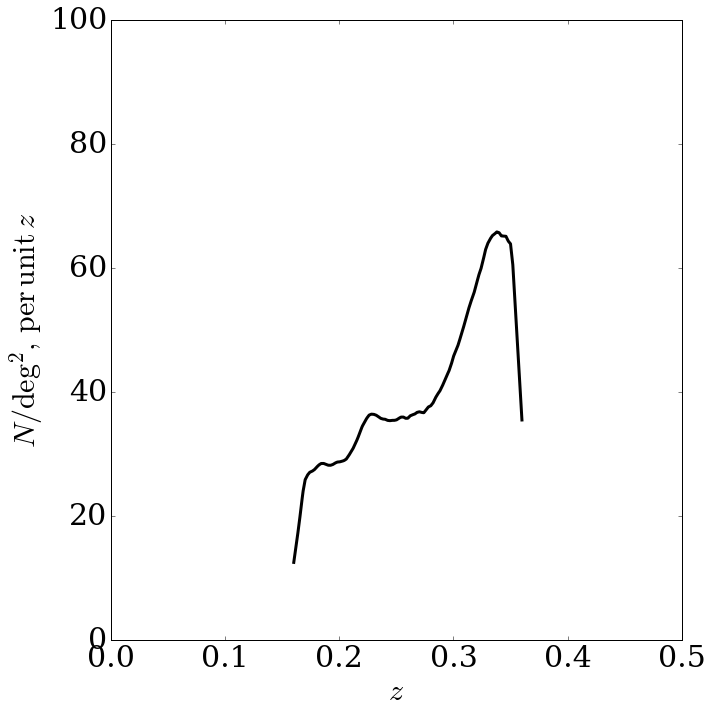

In [7]:
# SDSS LRG lenses

plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "serif"
plt.plot(z_SDSS, dNdzl_SDSS, 'k', linewidth=3)
plt.ylim(0, 100)
plt.xlim(0, 0.5)
plt.xlabel('$z$', fontsize=30)
plt.ylabel('$N / {\\rm deg}^2, \, {\\rm per\, unit\,} z$', fontsize=30)
plt.tick_params(axis='both', labelsize='30')
plt.tight_layout()
#plt.show()
plt.savefig('./plots/NofZ_lens_SDSS_fixdNdz.png')

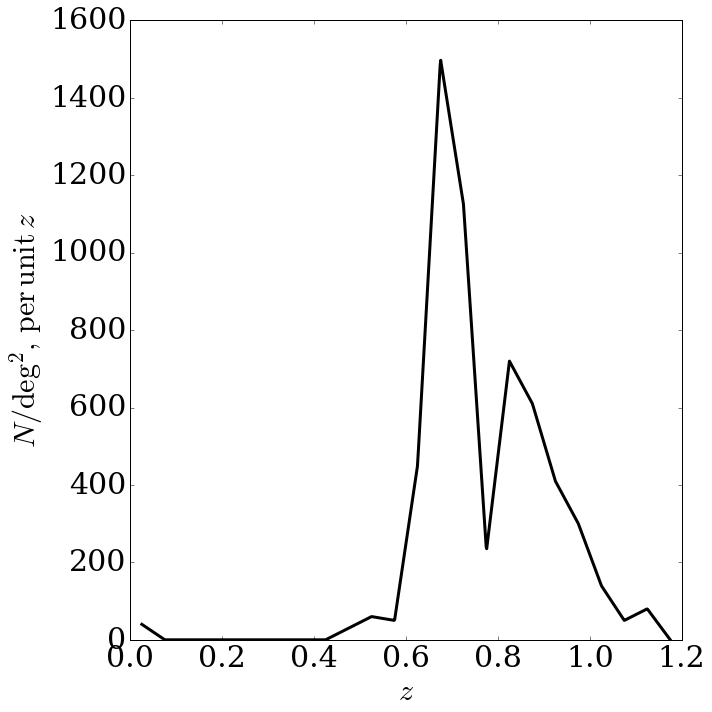

In [9]:
# DESI LRG lenses

plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "serif"
plt.plot(z_DESI, dNdzl_DESI, 'k', linewidth=3)
plt.xlabel('$z$', fontsize=30)
plt.ylabel('$N / {\\rm deg}^2, \, {\\rm per\, unit\,} z$', fontsize=30)
plt.tick_params(axis='both', labelsize='30')
plt.tight_layout()
#plt.show()
plt.savefig('./plots/NofZ_lens_DESI.png')

In [10]:
(z_SDSS_src, dNdz_unorm_SDSS) = setup.get_NofZ_unnormed([2.338, 0.303], 'Nakajima', 0., 1.5, 1000)
norm = scipy.integrate.simps(dNdz_unorm_SDSS, z_SDSS_src)
dNdz_SDSS = dNdz_unorm_SDSS / norm

(z_LSST_src, dNdz_unorm_LSST) = setup.get_NofZ_unnormed([1.24, 0.51, 1.01], 'Smail', 0., 5.0, 1000)
norm = scipy.integrate.simps(dNdz_unorm_LSST, z_LSST_src)
dNdz_LSST = dNdz_unorm_LSST / norm

0.82282219608
3609.5924628


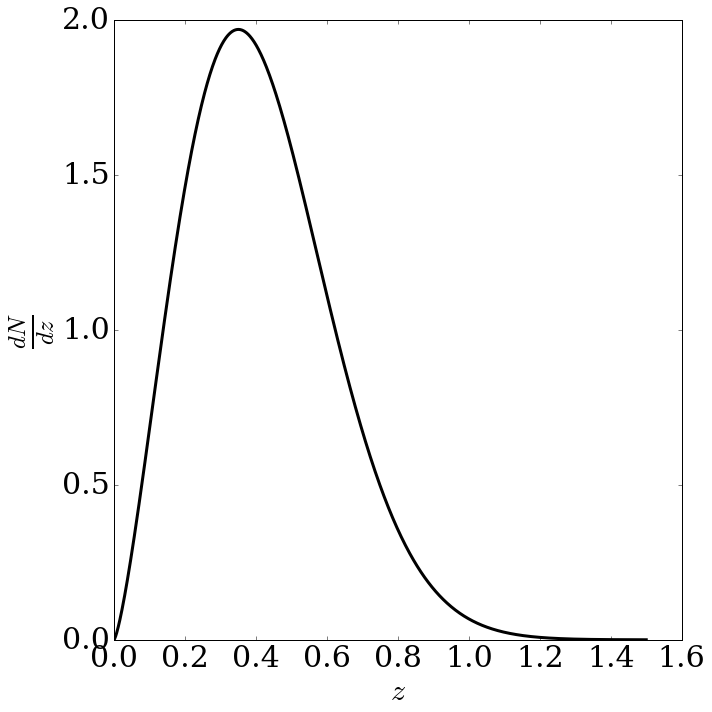

In [12]:
# SDSS shapes sources

Nnu	=	3.046    # Massless neutrinos
HH0 = 67.26 
OmR	=	2.47*10**(-5)/(HH0/100.)**2
OmN	=	Nnu*(7./8.)*(4./11.)**(4./3.)*OmR
OmB	=	0.02222/(HH0/100.)**2 
OmC	=	0.1199/(HH0/100.)**2 

(zcom, comz) = setup.z_interpof_com('LSST_DESI')

print zcom(comz(0.77) + 100)

print comz(zcom(comz(0.77) + 100)) * (1. + zcom(comz(0.77) + 100))

plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "serif"
plt.plot(z_SDSS_src, dNdz_SDSS, 'k', linewidth=3)
plt.xlabel('$z$', fontsize=30)
plt.ylabel('$\\frac{dN}{dz}$', fontsize=35)
plt.tick_params(axis='both', labelsize='30')
plt.tight_layout()
plt.show()
#plt.savefig('./plots/NofZ_source_SDSS.png')


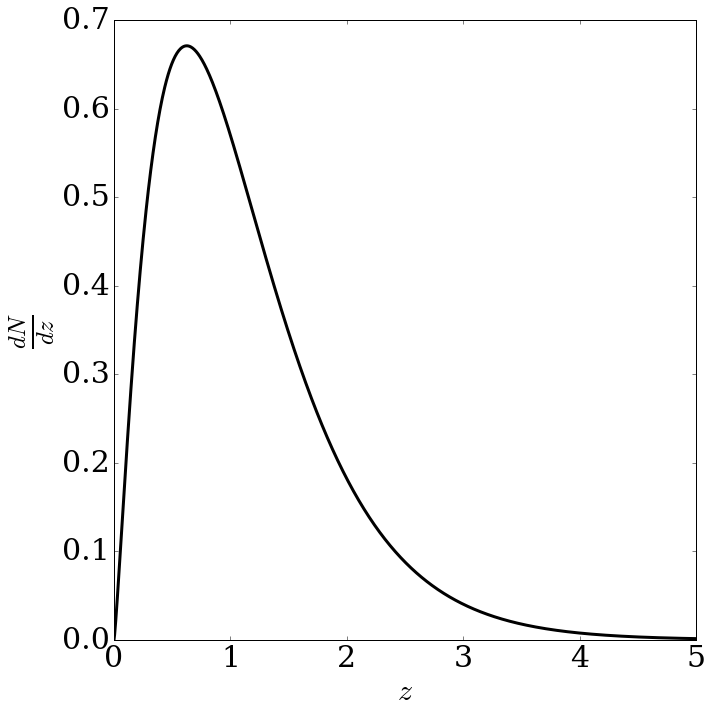

In [13]:
# LSST shapes sources

plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "serif"
plt.plot(z_LSST_src, dNdz_LSST, 'k', linewidth=3)
plt.xlabel('$z$', fontsize=30)
plt.ylabel('$\\frac{dN}{dz}$', fontsize=35)
plt.tick_params(axis='both', labelsize='30')
plt.tight_layout()
#plt.show()
plt.savefig('./plots/NofZ_source_LSST.png')

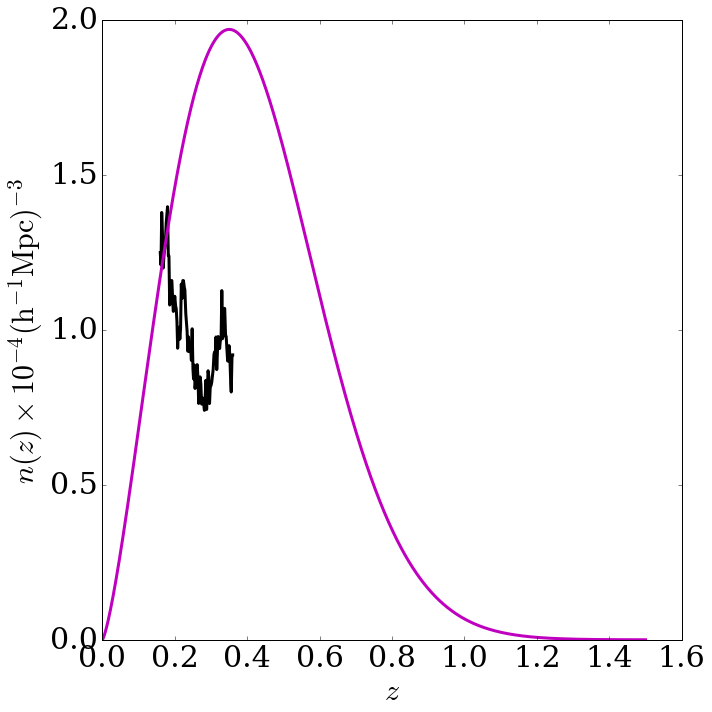

In [14]:
# Plot both SDSS sources and lenses on the same figure for intuition
plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "serif"
plt.plot(z_SDSS, dNdzl_SDSS, 'k', linewidth=3)
plt.hold(True)
plt.plot(z_SDSS_src, dNdz_SDSS, 'm', linewidth=3)
plt.xlabel('$z$', fontsize=30)
plt.ylabel('$n(z) \\times 10^{-4} ({\\rm h}^{-1} {\\rm Mpc})^{-3}}$', fontsize=30)
plt.tick_params(axis='both', labelsize='30')
plt.tight_layout()
#plt.show()
plt.savefig('./plots/NofZ_lens_source_SDSS.png')

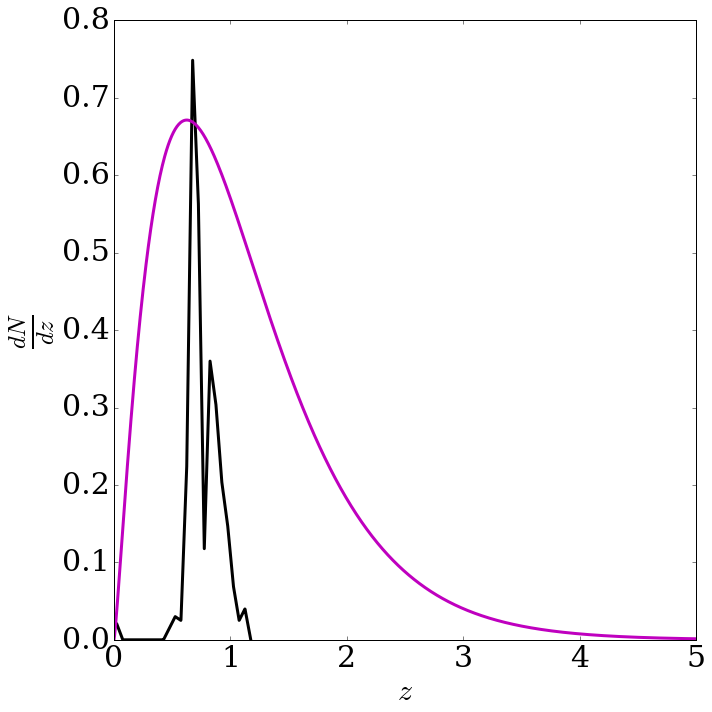

In [15]:
# Plot LSST sources and DESI lenses on the same plot for intuition
plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "serif"
plt.plot(z_DESI, dNdzl_DESI / 2000., 'k', linewidth=3)
plt.hold(True)
plt.plot(z_LSST_src, dNdz_LSST, 'm', linewidth=3)
plt.xlabel('$z$', fontsize=30)
plt.ylabel('$\\frac{dN}{dz}$', fontsize=35)
plt.tick_params(axis='both', labelsize='30')
plt.tight_layout()
#plt.show()
plt.savefig('./plots/NofZ_lens_source_LSST.png')